<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/Denoising_Autoencoder_Training_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading all the needed things

__Note__: This only trains the autoencoder. For subsequent classification. See Encoder+CNN

In [1]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 4310, done.
remote: Counting objects: 100% (588/588), done.
remote: Compressing objects: 100% (366/366), done.
remote: Total 4310 (delta 223), reused 584 (delta 219), pack-reused 3722
Receiving objects: 100% (4310/4310), 973.54 MiB | 25.55 MiB/s, done.
Resolving deltas: 100% (808/808), done.
Checking out files: 100% (2957/2957), done.
/content/STAT3007_Project


In [2]:
pip install colorednoise

  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp37-none-any.whl size=3983 sha256=fef1130cb364b884d70ab2832a43bdba7048e764aed0cf51d2fc4116be6375f6
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


In [3]:
import librosa
from librosa import display
import colorednoise as cn
import torch
import numpy as np
from IPython.display import Audio
import glob
from pre_process import *
from data_loading import *
import os
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor

import scipy
from torchsummary import summary


# load our own python files
from pre_process import *
from data_loading import *
from Models import *
from Model_Functions import *

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount= True)

Mounted at /content/drive


# load the spectrogram data

In [5]:
# here, the first number means the data was split for once, and it belonged to the that split e.g. noisy_6 contains data split into the 60% once.
# two numbers mean that data was split for twice, it belonged to the first split and the second split e.g. noisy_4_8 contains data split into 40% first, and 80% for second split.

# the first split of noisy data is for autoencoder training, then second split on the first test split is for subsequent classification training.

noisy_6 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/noisy_6.npy')
clean_6 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/clean_6.npy')
targets_6 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/target_6.npy')


noisy_4 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/noisy_4.npy')
clean_4 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/clean_4.npy')
targets_4 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/targets_4.npy')

noisy_4_8 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/noisy_4_8.npy')
noisy_4_2 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/noisy_4_2.npy')
clean_4_8 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/clean_4_8.npy')
clean_4_2 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/clean_4_2.npy')
targets_4_8 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/targets_4_8.npy')
targets_4_2 = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_1185/targets_4_2.npy')



In [6]:
# reshape
noisy_6 = noisy_6.reshape(noisy_6.shape[0],1,noisy_6.shape[1],noisy_6.shape[2])
clean_6 = clean_6.reshape(clean_6.shape[0],1,clean_6.shape[1],clean_6.shape[2])

noisy_4 = noisy_4.reshape(noisy_4.shape[0],1,noisy_4.shape[1],noisy_4.shape[2])
clean_4 = clean_4.reshape(clean_4.shape[0],1,clean_4.shape[1],clean_4.shape[2])

noisy_4_8 = noisy_4_8.reshape(noisy_4_8.shape[0],1,noisy_4_8.shape[1],noisy_4_8.shape[2])
clean_4_8 = clean_4_8.reshape(clean_4_8.shape[0],1,clean_4_8.shape[1],clean_4_8.shape[2])
noisy_4_2 = noisy_4_2.reshape(noisy_4_2.shape[0],1,noisy_4_2.shape[1],noisy_4_2.shape[2])
clean_4_2 = clean_4_2.reshape(clean_4_2.shape[0],1,clean_4_2.shape[1],clean_4_2.shape[2])

In [7]:
# make them into datasets
denoise_train = DatasetWrapper(torch.tensor(noisy_6), torch.tensor(clean_6))
denoise_test = DatasetWrapper(torch.tensor(noisy_4), torch.tensor(clean_4))

# Train

In [8]:

def train_model(data, net, loss, nepoch , optim_name='Adam' ,lr = 0.01, batch_size = -1, use_cuda = False, print_output = True, test_data=None):
  
  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    # print()
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  if optim_name == 'Adam':
    optimizer = optim.Adam(net.parameters(), lr = lr)
  if optim_name == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr = lr)
  if optim_name == 'Adagrad':
    optimizer = optim.Adagrad(net.parameters(), lr = lr)
  if optim_name == 'RMSprop':
    optimizer = optim.RMSprop(net.parameters(), lr = lr)
  else:
    optimizer = optim.Adam(net.parameters(), lr = lr)
  # print(type(data))
  data = data.change_type(dtype)
  test_data = test_data.change_type(dtype)

  # test data
  if test_data != None:
      X_test, y_test = test_data.get_data()
    #   X_test = X_test.to('cpu')
    #   y_test = y_test.to('cpu')
      # print(type(X_test))
      test_losses = []

  if batch_size == -1:
    data_loader = DataLoader(data,
                         batch_size = data.dataset__len__, shuffle = True)
  
  else:
    data_loader = DataLoader(data,
                             batch_size = batch_size, shuffle = True)

  train_losses = []

  for epoch in range(nepoch):
     batch_losses = []
     for X_batch, y_batch in data_loader:
      # y_batch = y_batch.reshape(y_batch.shape[0],1,y_batch.shape[1],y_batch.shape[2])
      if use_cuda and device != None:
        # net = net.to(device)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

      optimizer.zero_grad()

      # since all our values are negative, we convert them to positive
      
      # print(next(net.parameters()).is_cuda)
      # print(id(net))
      pred = net(X_batch)

      Rn = loss(pred, y_batch)
      Rn.backward()
      optimizer.step()
      batch_losses.append(Rn.item())
     avg_loss = np.mean(np.array(batch_losses))
     train_losses.append(avg_loss)

     if test_data != None:
         # net_test = net.to(torch.device('cpu'))
         # net_test = net
         # print(id(net_test))
         test_pred = net(X_test)
         test_error = loss(test_pred, y_test)
         test_losses.append(test_error.item())

     if print_output:
      print('epoch:', epoch)
      print('loss:', avg_loss)
      print('------------')
     
    
  print('final loss:', Rn.item())

  if test_data != None:
    return net, train_losses, test_losses
  else:
    return net, train_losses, None

In [12]:
# hyperparameters and training

loss = nn.MSELoss()
torch.manual_seed(10)
AE = Autoencoder(16, (4,2), (59,30),(125,62))
lr = 0.01
nepoch = 50
net, train_loss_log, test_loss_log = train_model(denoise_train,AE, loss, test_data=denoise_test ,nepoch = nepoch,lr = lr, batch_size = 30, use_cuda = True,print_output = False)


final loss: 91.51001739501953


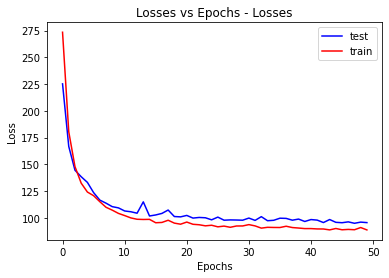

In [13]:
plt.plot(np.arange(len(test_loss_log)), test_loss_log, color='blue', label='test')
plt.plot(np.arange(len(train_loss_log)), train_loss_log, color='red', label='train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses vs Epochs - Losses')
plt.show()

# Save model parameters

In [ ]:
state_save_path = '/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/denoised_saved_model_parameters'
torch.save(net.state_dict(), state_save_path)

In [ ]:
model = Autoencoder(16, (4,2), (59,30),(125,62))
model.load_state_dict(torch.load(state_save_path))

<All keys matched successfully>

<class '__main__.Autoencoder'>


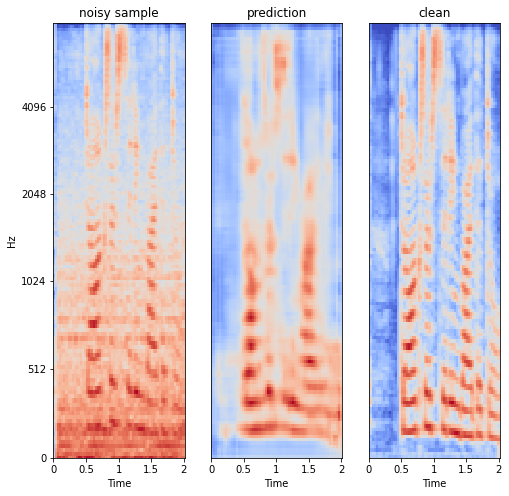

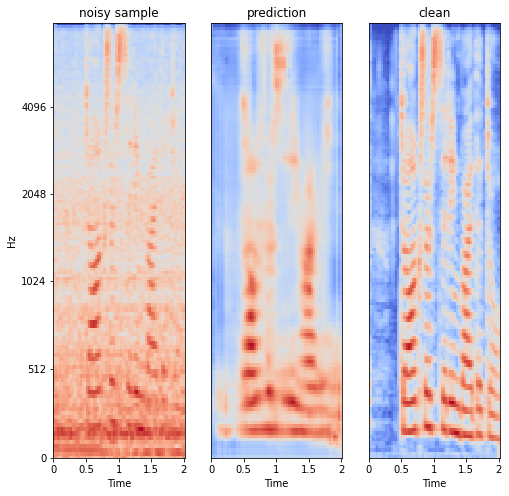

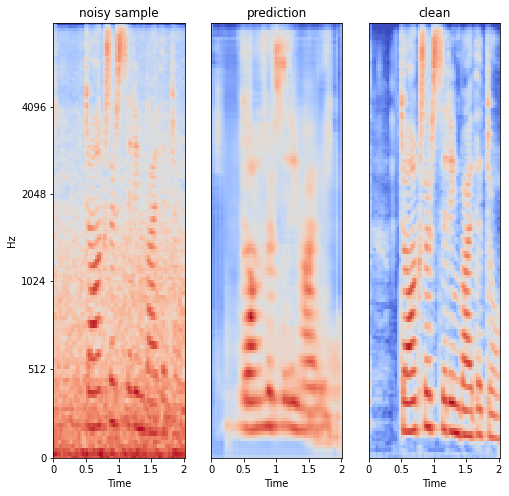

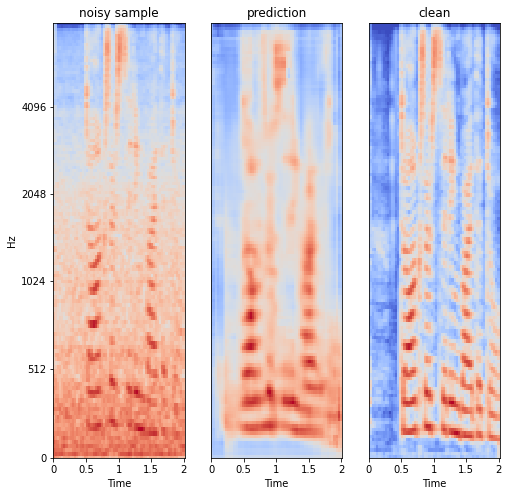

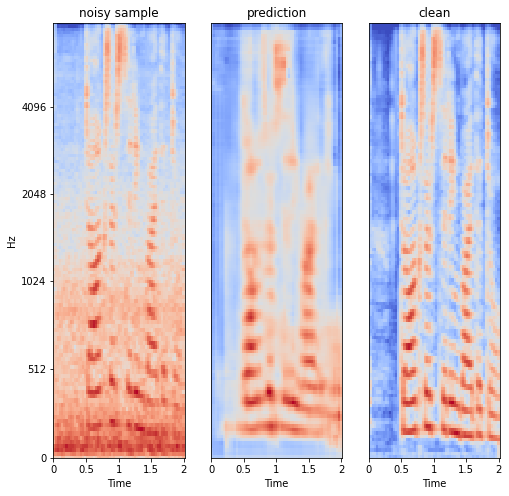

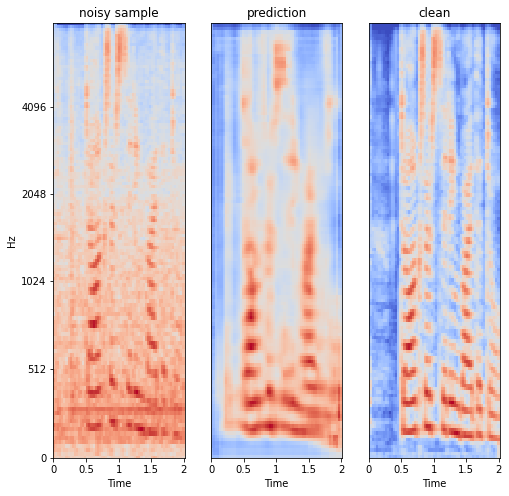

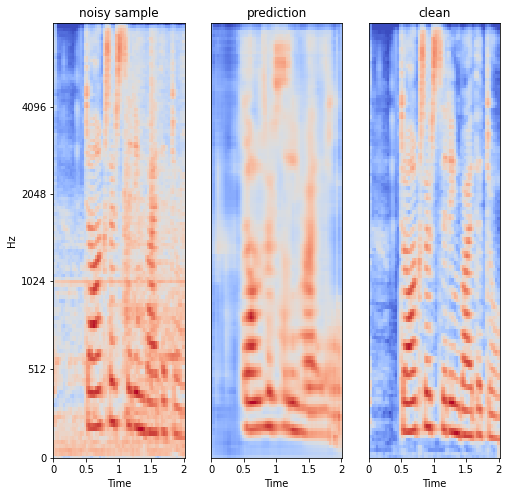

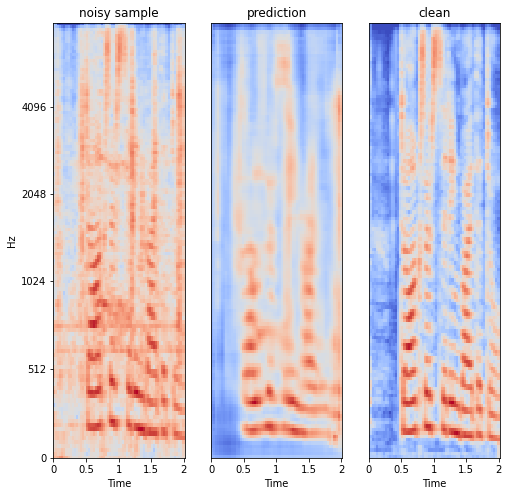

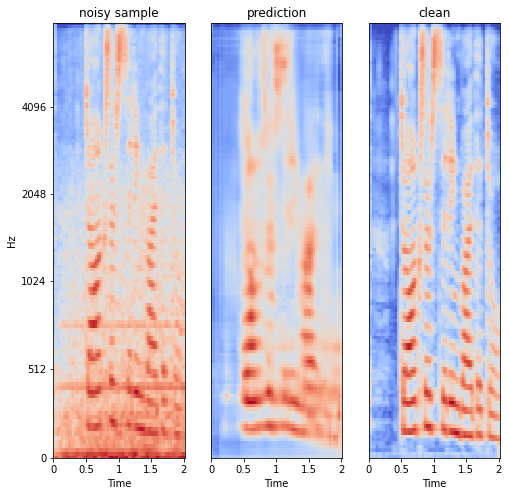

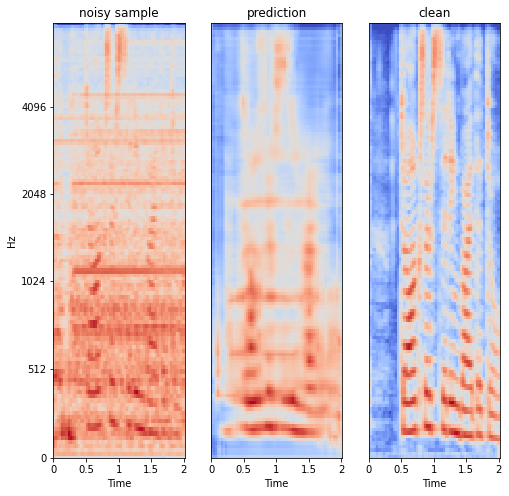

In [ ]:
X_test, y_test = denoise_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
if (device == torch.device('cuda')):
    model = model.to(torch.device('cpu'))
print(type(model))
y_pred = model(X_test)

for i in range(10):
    plt.figure(figsize = (8,8))
    plt.subplot2grid((1,3),(0,0))
    librosa.display.specshow(X_test[i,0].detach().numpy(), y_axis='mel', fmax=8000, x_axis='time', sr =16000);
    plt.title('noisy sample')

    plt.subplot2grid((1,3),(0,1))
    librosa.display.specshow(y_pred[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('prediction')


    ax = plt.subplot2grid((1,3),(0,2))
    librosa.display.specshow(y_test[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('clean')
    plt.show()

# Save model

In [ ]:
state_save_path = '/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/denoised_saved_model'

In [ ]:
torch.save(net, state_save_path)

In [ ]:
the_model = torch.load(state_save_path)


<class '__main__.Autoencoder'>


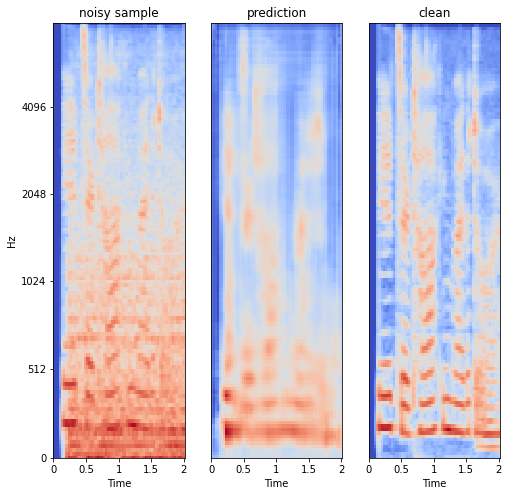

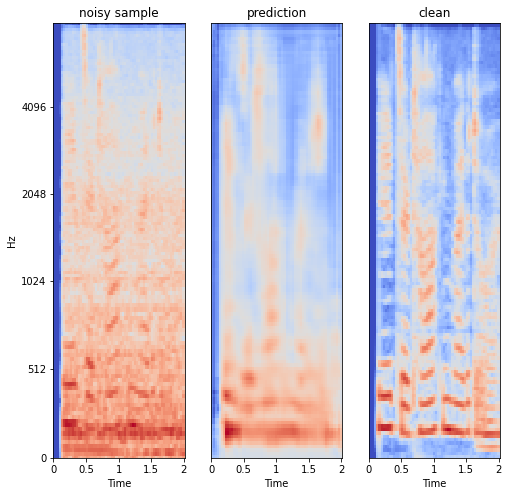

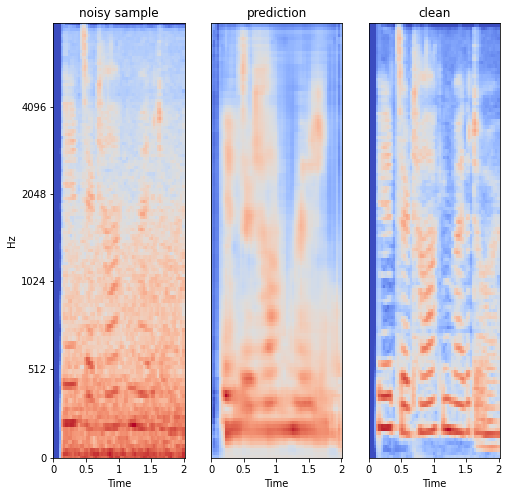

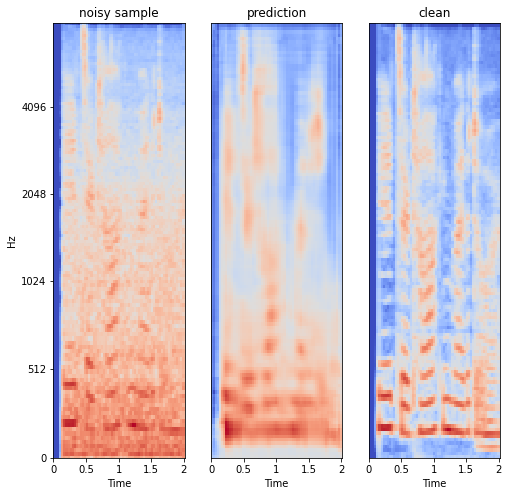

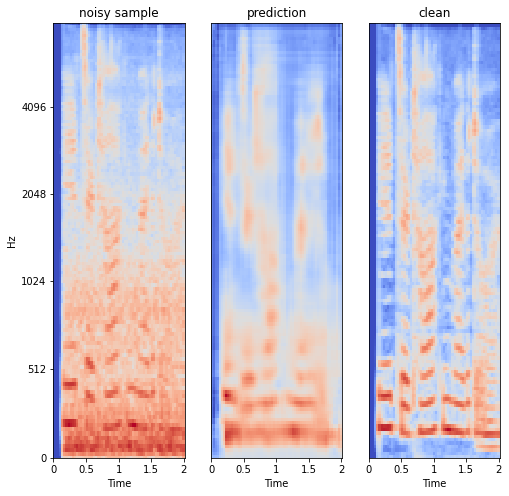

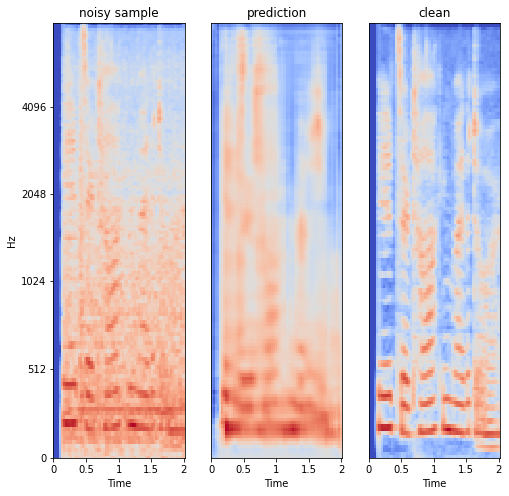

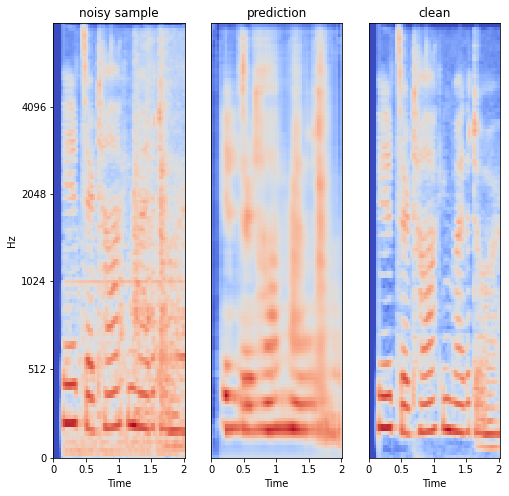

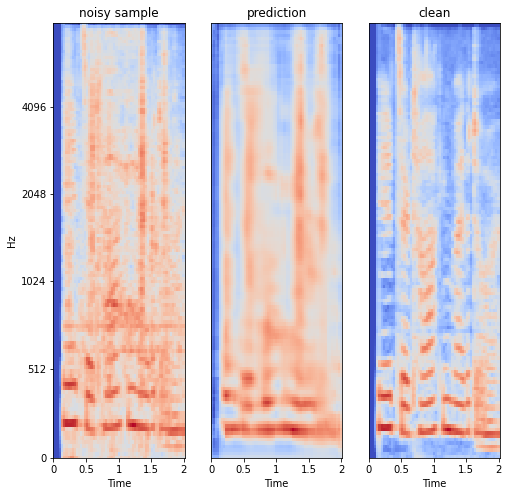

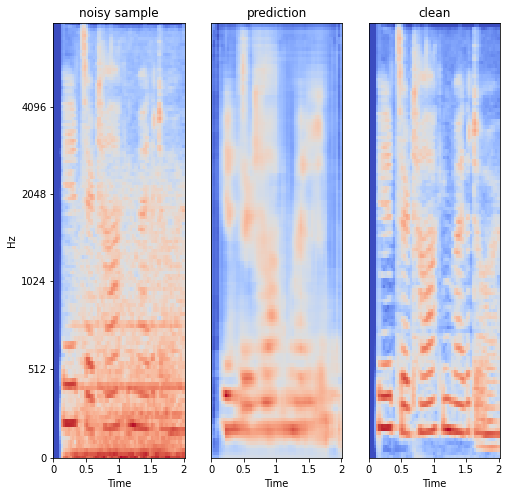

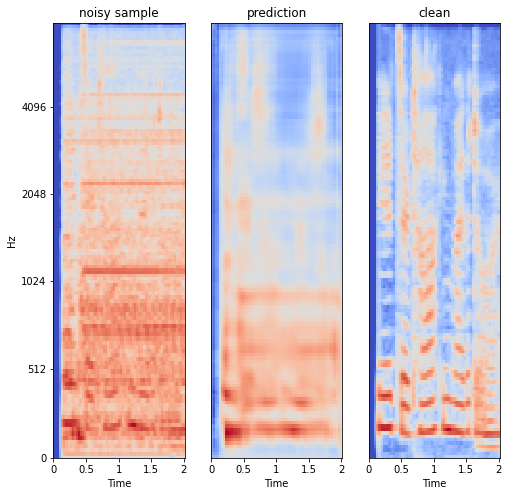

In [ ]:
X_test, y_test = denoise_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
if (device == torch.device('cuda')):
    the_model = the_model.to(torch.device('cpu'))
print(type(the_model))
y_pred = the_model(X_test)

for i in range(10):
    plt.figure(figsize = (8,8))
    plt.subplot2grid((1,3),(0,0))
    librosa.display.specshow(X_test[i,0].detach().numpy(), y_axis='mel', fmax=8000, x_axis='time', sr =16000);
    plt.title('noisy sample')

    plt.subplot2grid((1,3),(0,1))
    librosa.display.specshow(y_pred[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('prediction')


    ax = plt.subplot2grid((1,3),(0,2))
    librosa.display.specshow(y_test[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('clean')
    plt.show()